In [ ]:
# %%

import numpy as np
import pymc as pm
import arviz as az
import pytensor.tensor as tt
import matplotlib.pyplot as plt


class BayesianPCA:
    def __init__(self, t, q, a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3):
        self.t = t
        self.N, self.d = t.shape
        self.q = q
        self.a_alpha = a_alpha
        self.b_alpha = b_alpha
        self.a_tau = a_tau
        self.b_tau = b_tau
        self.beta = beta

    def fit(self, iterations=1000, method='nuts'):
        with pm.Model() as model:
            # Priors
            mu = pm.Normal('mu', mu=0, sigma=np.sqrt(1/self.beta), shape=self.d)
            tau = pm.Gamma('tau', alpha=self.a_tau, beta=self.b_tau)
            alpha = pm.Gamma('alpha', alpha=self.a_alpha, beta=self.b_alpha, shape=self.q)
            
            W = pm.MatrixNormal('W', mu=np.zeros((self.d, self.q)), 
                                rowcov=np.eye(self.d), colcov=tt.diag(1/alpha))

            # Latent variables
            x = pm.Normal('x', mu=0, sigma=1, shape=(self.N, self.q))
            
            # Likelihood
            t_obs = pm.MatrixNormal('t_obs', mu=pm.math.dot(x, W.T) + mu, 
                                    rowcov=np.eye(self.N), colcov=np.eye(self.d) / tau, observed=self.t)

            # Sampling method
            if method == 'nuts':
                trace = pm.sample(iterations, return_inferencedata=True, progressbar=True)
            elif method == 'metropolis':
                trace = pm.sample(iterations, step=pm.Metropolis(), return_inferencedata=True, progressbar=True)
            elif method == 'slice':
                trace = pm.sample(iterations, step=pm.Slice(), return_inferencedata=True, progressbar=True)
            elif method == 'hmc':
                trace = pm.sample(iterations, step=pm.HamiltonianMC(), return_inferencedata=True, progressbar=True)
            elif method == 'smc':
                trace = pm.sample_smc(iterations, progressbar=True)

        self.trace = trace

In [ ]:
# %%

def simulate_data(psi=1, N=100, P=10):
    psi_inv = 1 / psi
    cov = np.diag([5, 4, 3, 2] + [psi_inv] * (P - 4))

    # Generate a random orthogonal matrix U
    random_matrix = np.random.randn(P, P)
    U, _, _ = np.linalg.svd(random_matrix)
    
    # Transform the covariance matrix
    cov = U @ cov @ U.T

    return np.random.multivariate_normal(np.zeros(P), cov, N)

In [ ]:
# %%

# Simulate data with noise
var_noise = 1e-2
data = simulate_data(
    psi=var_noise**(-1), 
    N=100
    )

In [ ]:
# %%

bpca = BayesianPCA(data, q=data.shape[1] - 1)
bpca.fit(
    iterations=100,
    # method='nuts',
    method = 'metropolis'
    )

/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Us

Output()

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 256 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

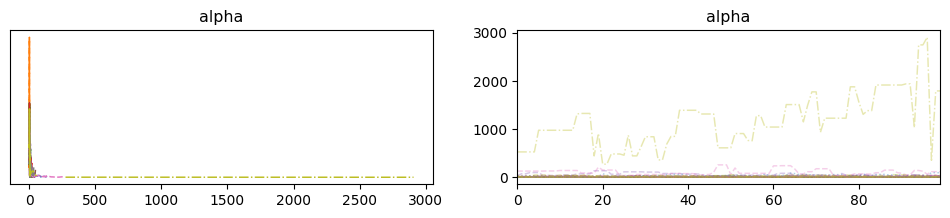

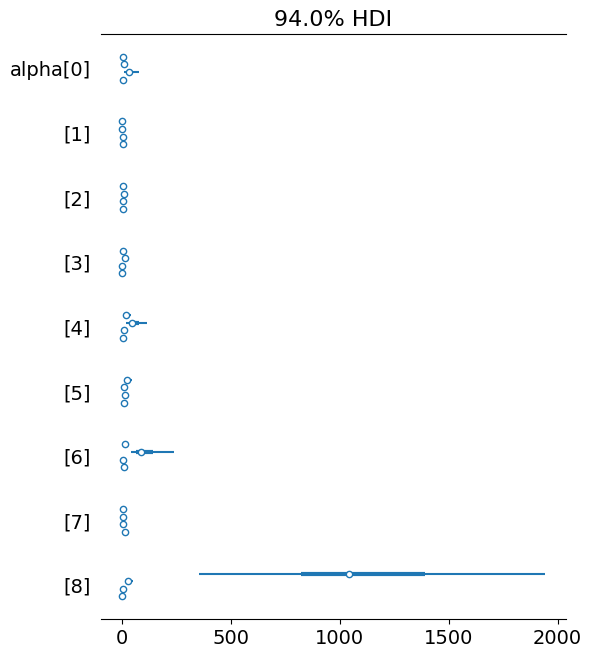

In [ ]:
# %%

# results of alpha, expectation of alpha
az.plot_trace(bpca.trace, var_names=['alpha'])
az.plot_forest(bpca.trace, var_names=['alpha'])

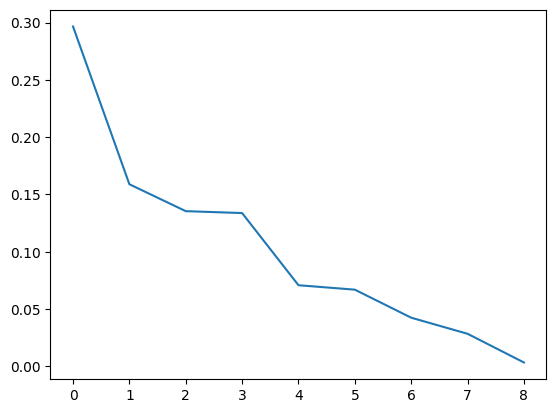

In [ ]:
# %%

# mean of samples of alpha
alpha_samples = bpca.trace.posterior['alpha'].values
alpha_samples_mean = alpha_samples.mean(axis=(0,1))
plt.plot(sorted(alpha_samples_mean**(-1), reverse=True))

In [ ]:
# %%

bpca = BayesianPCA(data, q=data.shape[1] - 1)
bpca.fit(
    iterations=1000,
    # method='nuts',
    method = 'metropolis'
    )

/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Us

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 520 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

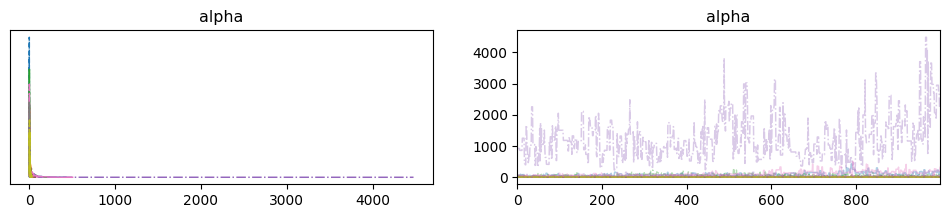

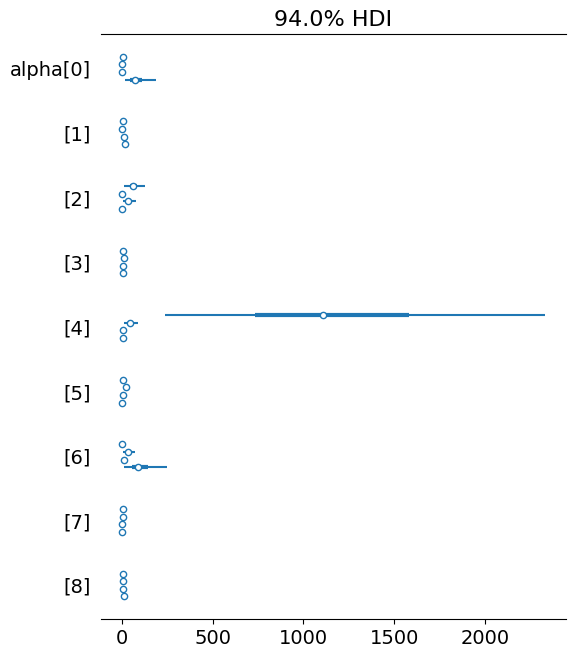

In [ ]:
# %%

# results of alpha, expectation of alpha
az.plot_trace(bpca.trace, var_names=['alpha'])
az.plot_forest(bpca.trace, var_names=['alpha'])

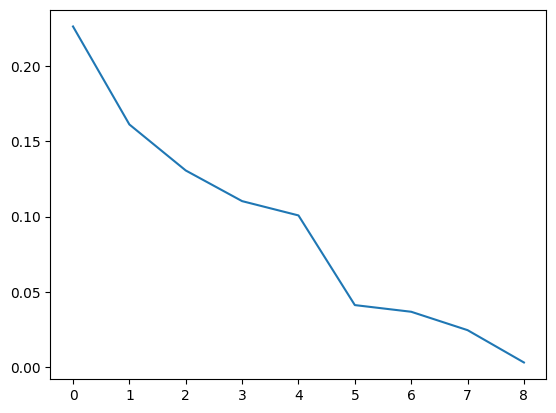

In [ ]:
# %%

# mean of samples of alpha
alpha_samples = bpca.trace.posterior['alpha'].values
alpha_samples_mean = alpha_samples.mean(axis=(0,1))
plt.plot(sorted(alpha_samples_mean**(-1), reverse=True))

In [ ]:
# %%

# Simulate data with noise
var_noise = 1e-3
data = simulate_data(
    psi=var_noise**(-1), 
    N=100
    )

In [ ]:
# %%

bpca = BayesianPCA(data, q=data.shape[1] - 1)
bpca.fit(
    iterations=1000,
    # method='nuts',
    method = 'metropolis'
    )

/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Us

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 529 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

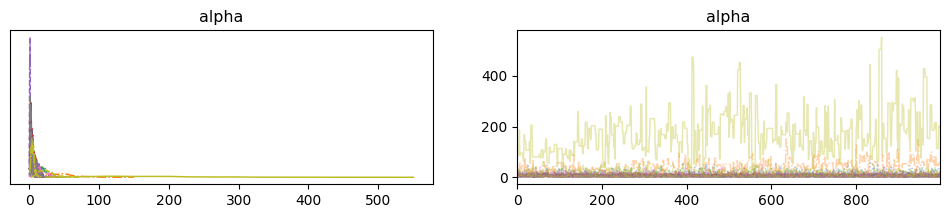

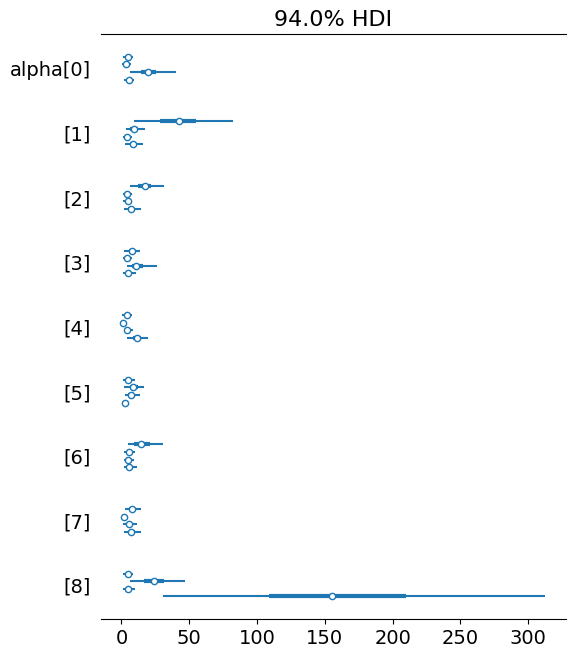

In [ ]:
# %%

# results of alpha, expectation of alpha
az.plot_trace(bpca.trace, var_names=['alpha'])
az.plot_forest(bpca.trace, var_names=['alpha'])

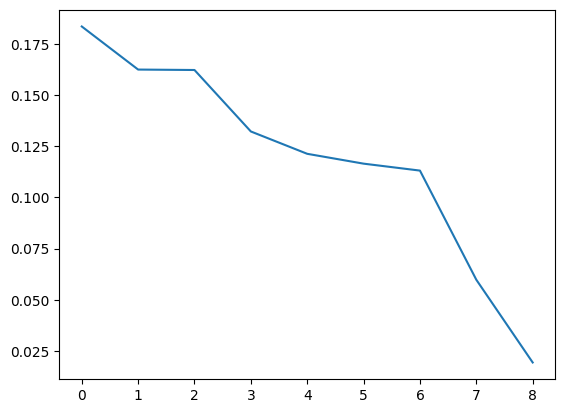

In [ ]:
# %%

# mean of samples of alpha
alpha_samples = bpca.trace.posterior['alpha'].values
alpha_samples_mean = alpha_samples.mean(axis=(0,1))
plt.plot(sorted(alpha_samples_mean**(-1), reverse=True))